In [1]:
# boilerplate code
from __future__ import print_function
import os
from io import BytesIO
import numpy as np
from functools import partial
import PIL.Image
from IPython.display import clear_output, Image, display, HTML
import tensorflow as tf

In [2]:
tf.reset_default_graph()
model_fn = 'inception5h/tensorflow_inception_graph.pb'


# creating TensorFlow session and loading the model
graph = tf.Graph()
sess = tf.InteractiveSession(graph=graph)
with tf.gfile.FastGFile(model_fn, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
t_input = tf.placeholder(np.float32, name='input') # define the input tensor
imagenet_mean = 117.0
t_preprocessed = tf.expand_dims(t_input-imagenet_mean, 0)
Guide=tf.placeholder(tf.float32,name='Guide')
tf.import_graph_def(graph_def, {'input':t_preprocessed})

In [3]:
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = tf.compat.as_bytes("<stripped %d bytes>"%size)
    return strip_def

In [4]:
def rename_nodes(graph_def, rename_func):
    res_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = res_def.node.add() 
        n.MergeFrom(n0)
        n.name = rename_func(n.name)
        for i, s in enumerate(n.input):
            n.input[i] = rename_func(s) if s[0]!='^' else '^'+rename_func(s[1:])
    return res_def

In [ ]:
# Write graph definition to a local log-file to be able to visualize it on tensorboard
LOGDIR='tmp/inception_log/'
train_writer = tf.summary.FileWriter(LOGDIR)
train_writer.add_graph(sess.graph)

In [5]:

# start with a gray image with a little noise
img_noise = np.random.uniform(size=(500,720,3)) + 100.0

def save_image(a,name,fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    PIL.Image.fromarray(a).save('.'.join([name,fmt]))


def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f,fmt)
    display(Image(data=f.getvalue()))

def T(layer):
    '''Helper for getting layer output tensor'''
    return graph.get_tensor_by_name("import/%s:0"%layer)

In [6]:
def tffunc(*argtypes):
    '''Helper that transforms TF-graph generating function into a regular one.
    See "resize" function below.
    '''
    placeholders = list(map(tf.placeholder, argtypes))
    def wrap(f):
        out = f(*placeholders)
        def wrapper(*args, **kw):
            return out.eval(dict(zip(placeholders, args)), session=kw.get('session'))
        return wrapper
    return wrap

# Helper function that uses TF to resize an image
def resize(img, size):
    img = tf.expand_dims(img, 0)
    return tf.image.resize_bilinear(img, size)[0,:,:,:]
resize = tffunc(np.float32, np.int32)(resize)

def calc_grad_tiled(img, t_grad, tile_size=512):
    '''Compute the value of tensor t_grad over the image in a tiled way.
    Random shifts are applied to the image to blur tile boundaries over 
    multiple iterations.'''
    sz = tile_size
    h, w = img.shape[:2]
    sx, sy = np.random.randint(sz, size=2)
    img_shift = np.roll(np.roll(img, sx, 1), sy, 0)
    grad = np.zeros_like(img)
    for y in range(0, max(h-sz//2, sz),sz):
        for x in range(0, max(w-sz//2, sz),sz):
            sub = img_shift[y:y+sz,x:x+sz]
            g = sess.run(t_grad, {t_input:sub})
            grad[y:y+sz,x:x+sz] = g
    return np.roll(np.roll(grad, -sx, 1), -sy, 0)

def calc_grad_guided(t_obj,img,guide,t_grad,tile_size=512):
    '''Compute the value of tensor t_grad over the image in a tiled way
    under the setting of guided deep dream.Random shifts are applied to 
    the image to blur tile boundaries over multiple iterations.'''
    sz = tile_size
    h, w = img.shape[:2]
    sx, sy = np.random.randint(sz, size=2)
    img_shift = np.roll(np.roll(img, sx, 1), sy, 0)
    guide_shift=np.roll(np.roll(guide, sx, 1), sy, 0)
    grad = np.zeros_like(img)
    for y in range(0, max(h-sz//2, sz),sz):
        for x in range(0, max(w-sz//2, sz),sz):
            sub = img_shift[y:y+sz,x:x+sz]
            sub_g=guide_shift[y:y+sz,x:x+sz]
            with tf.Session() as sess_1:
                guide_f=sess_1.run(t_obj,feed_dict={t_input:sub_g})[0]
            g = sess.run(t_grad, feed_dict={t_input:sub, Guide:guide_f})
            grad[y:y+sz,x:x+sz] = g
    return np.roll(np.roll(grad, -sx, 1), -sy, 0)

In [7]:
def objective_guide(t_obj,guide):
    # define objective function for the guided dream. Note: due to the fact that tensorflow relies on the
    # concept of computational graph, thus it's not possible to take gradients through operations that 
    # involve argmax and tf.gather, which makes the implemetation of guided dream very tricky. Thus I made 
    # a few adjustments, but the results are not as good as the caffe implementations. Further adjustments
    # will be made in the future.
    X= t_obj[0]
    ch = int(t_obj.shape[3])
    target_features=tf.reshape(X,[ch,-1])
    guide_features=tf.reshape(Guide,[ch,-1])
    A=target_features-guide_features
    obj=tf.square(A)
    return obj

In [8]:
def deepdream(t_obj, img0=img_noise,
            iter_n=10, step=1.5, octave_n=4, octave_scale=1.4):
    t_score = tf.reduce_mean(t_obj) # optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] #automatic differentiation with tensorflow

    # split the image into a number of octaves
    img = img0
    octaves = []
    for i in range(octave_n-1):
        hw = img.shape[:2]
        lo = resize(img, np.int32(np.float32(hw)/octave_scale))
        hi = img-resize(lo, hw)
        img = lo
        octaves.append(hi)
    
    # generate details octave by octave
    for octave in range(octave_n):
        if octave>0:
            hi = octaves[-octave]
            img = resize(img, hi.shape[:2])+hi
        for i in range(iter_n):
            g = calc_grad_tiled(img, t_grad)
            img += g*(step / (np.abs(g).mean()+1e-7))
            print('.',end = ' ')
        clear_output()
    return np.clip(img,0,255.0)

In [30]:
def deepdream_guided(t_obj, guide, img0=img_noise,
                     iter_n=10, step=1.5, octave_n=4, octave_scale=1.4):
    obj=objective_guide(t_obj,guide)
    t_score = tf.reduce_mean(obj) # optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] #automatic differentiation with tensorflow

    # split the image into a number of octaves
    img = img0
    octaves = []
    octaves_g=[]
    for i in range(octave_n-1):
        hw = img.shape[:2]
        lo = resize(img, np.int32(np.float32(hw)/octave_scale))
        lo_g=resize(guide,np.int32(np.float32(hw)/octave_scale))
        hi = img-resize(lo, hw)
        hi_g=guide-resize(lo, hw)
        img = lo
        guide=lo_g
        octaves.append(hi)
        octaves_g.append(hi_g)
    
    # generate details octave by octave
    for octave in range(octave_n):
        if octave>0:
            hi = octaves[-octave]
            hi_g=octaves_g[-octave]
            img = resize(img, hi.shape[:2])+hi
            guide=resize(guide, hi.shape[:2])+hi
        for i in range(iter_n):
            g = calc_grad_guided(t_obj,img,guide,t_grad)
            img += g*(step / (np.abs(g).mean()+1e-7))
            print('.',end = ' ')
        clear_output()
    return np.clip(img,0,255.0)

In [10]:
def r_deepdream(t_obj, img0=img_noise,
                     iter_n=10, step=1.5, octave_n=4, octave_scale=1.4):## Reversed deep dream
    
    t_score = tf.reduce_mean(t_obj) # optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] #automatic differentiation with tensorflow

    # split the image into a number of octaves
    img = img0
    octaves = []
    for i in range(octave_n-1):
        hw = img.shape[:2]
        lo = resize(img, np.int32(np.float32(hw)/octave_scale))
        hi = img-resize(lo, hw)
        img = lo
        octaves.append(hi)
    
    # generate details octave by octave
    for octave in range(octave_n):
        if octave>0:
            hi = octaves[-octave]
            img = resize(img, hi.shape[:2])+hi
        for i in range(iter_n):
            g = calc_grad_tiled(img, t_grad)
            img -= g*(step / (np.abs(g).mean()+1e-7))
            print('.',end = ' ')
        clear_output()
    return np.clip(img,0,255.0)

In [11]:
layer = ['mixed3a','mixed3b','mixed4a','mixed4b','mixed4c','mixed4d','mixed4e','mixed5a','mixed5b']

# Examples

In [109]:
frame=PIL.Image.open('city.jpg')
frame=np.float32(frame)
frame = deepdream(T(layer[5]),frame,iter_n=10,octave_n=18)

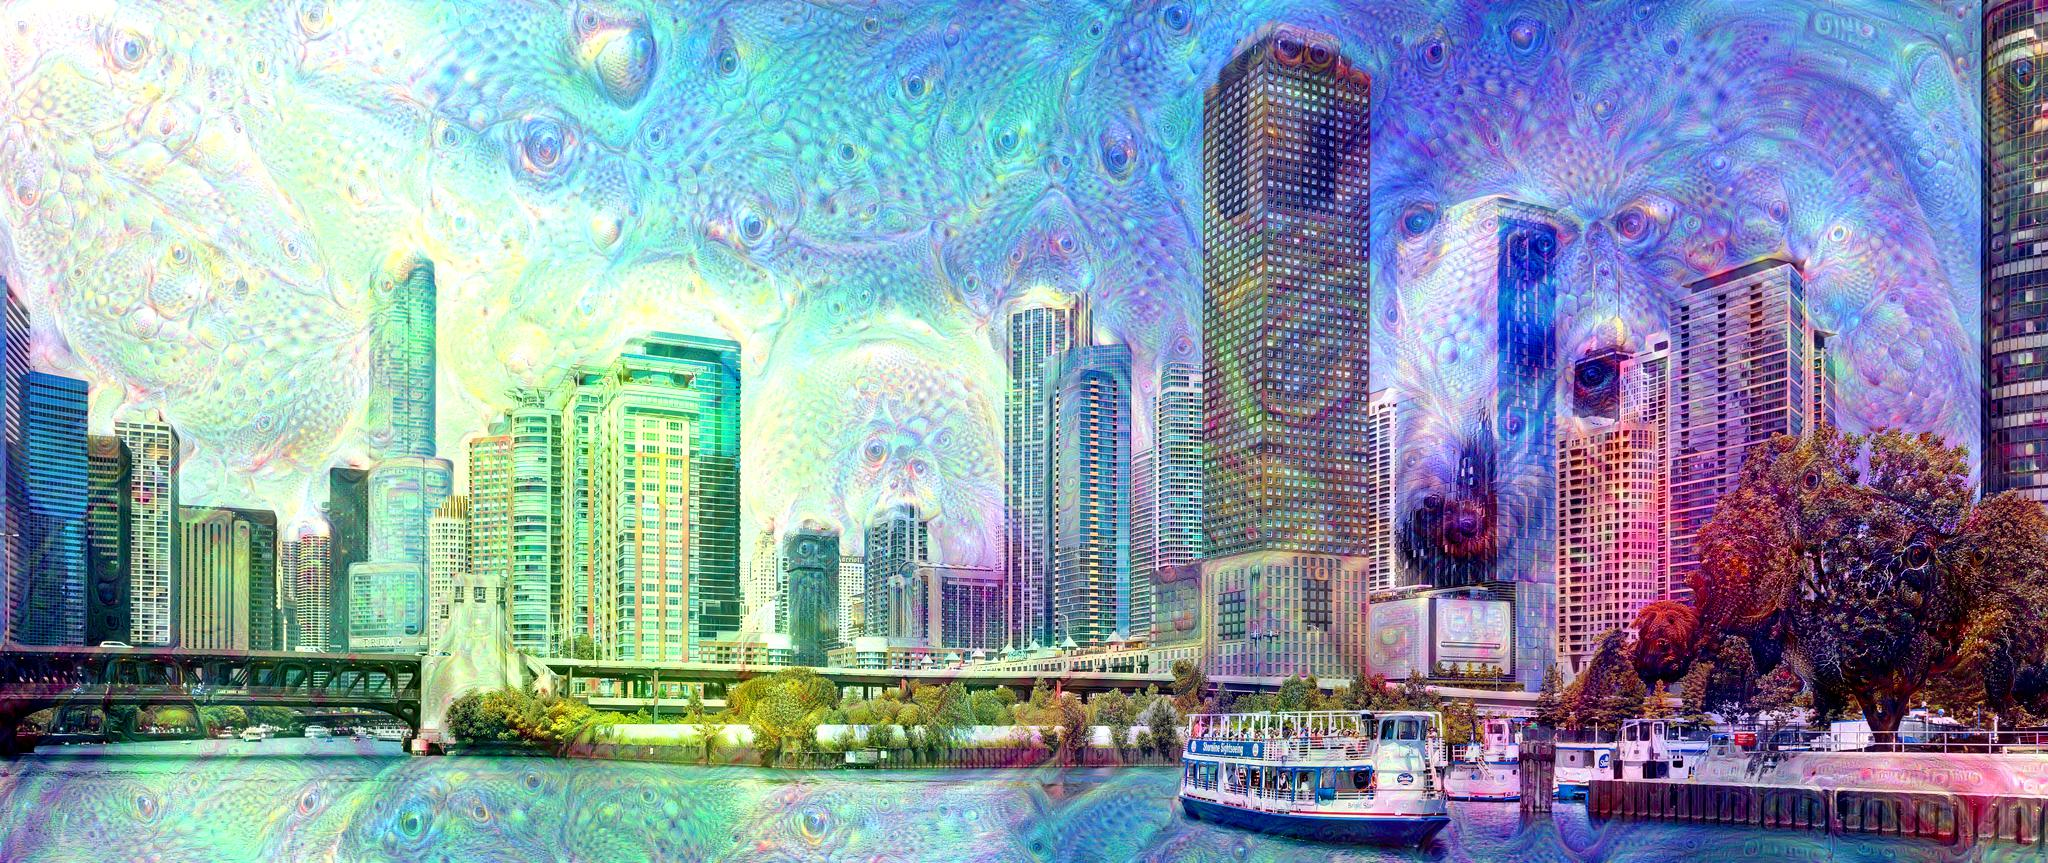

In [110]:
showarray(frame)

In [105]:
frame=PIL.Image.open('jungle.jpg')
frame=np.float32(frame)
frame = deepdream(T(layer[5]),frame,iter_n=10,octave_n=18)# Dream on inception 4d

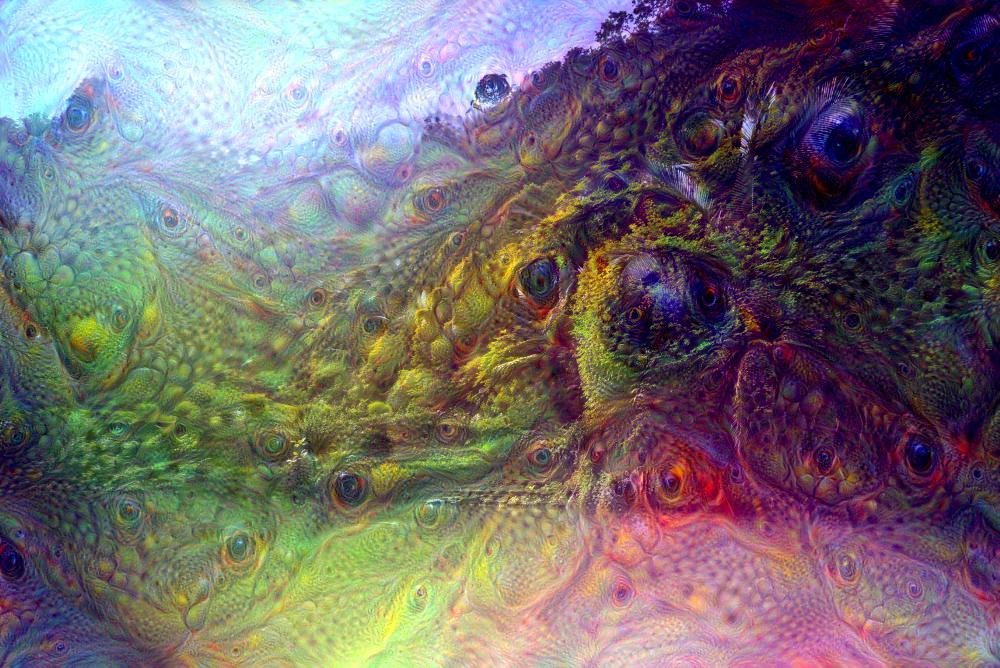

In [108]:
showarray(frame)

In [126]:
frame=PIL.Image.open('jungle.jpg')
frame=np.float32(frame)
frame = deepdream(T(layer[5])[0,:,:,55],frame,iter_n=30,octave_n=18)# Dream on a specific feature map, say 55th feature map

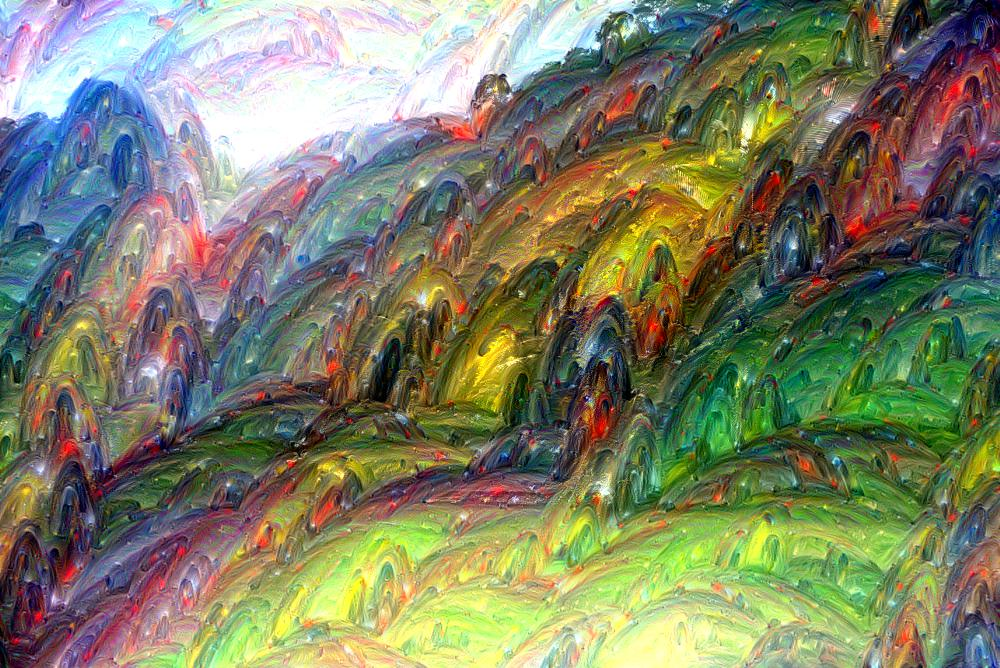

In [124]:
showarray(frame)

In [103]:
frame=PIL.Image.open('jungle.jpg')
frame=np.float32(frame)
frame = deepdream(T(layer[4])[0,:,:,15],frame,iter_n=30,octave_n=18)

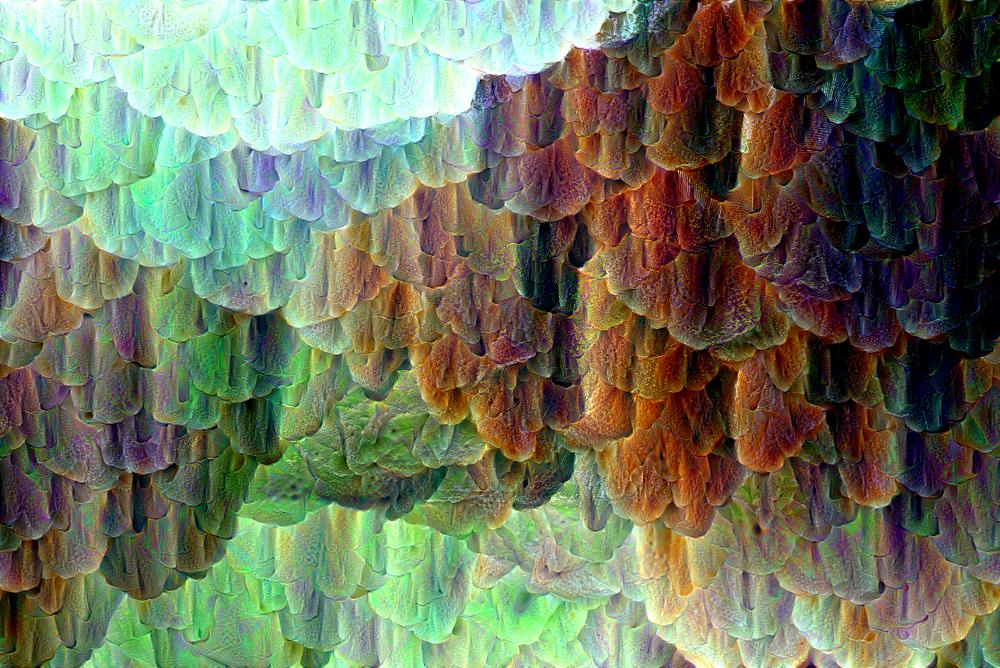

In [104]:
showarray(frame)

In [140]:
PIL.Image.fromarray(np.uint8(frame)).save('R.jpg')

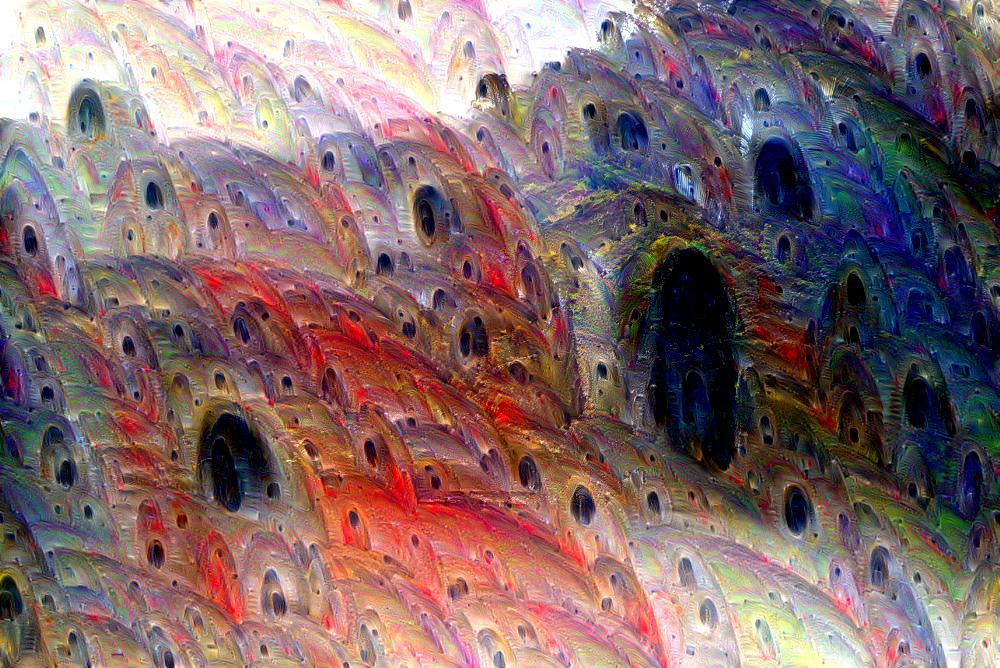

In [127]:
showarray(frame)

In [129]:
# reversed deep dream
frame=PIL.Image.open('jungle.jpg')
frame=np.float32(frame)
frame = r_deepdream(T('mixed4c_3x3_pre_relu'),frame,iter_n=30,octave_n=18)

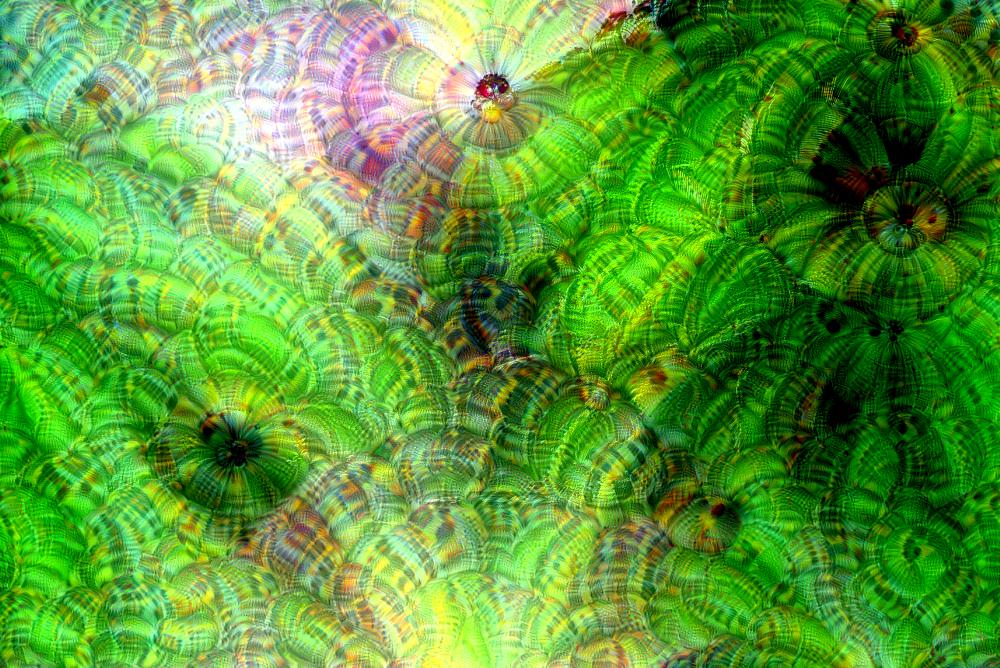

In [139]:
showarray(frame)

In [138]:
# reversed deep dream
frame=PIL.Image.open('jungle.jpg')
frame=np.float32(frame)
frame = r_deepdream(T('mixed4d_3x3_pre_relu'),frame,iter_n=30,octave_n=18)

In [136]:
# reversed deep dream
frame=PIL.Image.open('jungle.jpg')
frame=np.float32(frame)
frame = deepdream(T('mixed4d_3x3_pre_relu'),frame,iter_n=30,octave_n=18)